# Lab 3: Ensembles
## Using trees to detect trees 

We will be using tree-based ensemble methods on the [Covertype dataset](https://www.openml.org/d/180).
It contains about 100,000 observations of 7 types of trees (Spruce, Pine, Cottonwood, Aspen,...) described by 55 features describing elevation, distance to water, soil type, etc.

In [1]:
# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
import seaborn as sns

In [ ]:
# Download Covertype data. Takes a while the first time.
covertype = oml.datasets.get_dataset(180)
X, y, _, _ = covertype.get_data(target=covertype.default_target_attribute, dataset_format='array');
classes = covertype.retrieve_class_labels()
features = [f.name for i,f in covertype.features.items()][:-1]

In [3]:
classes

['Aspen',
 'Cottonwood_Willow',
 'Douglas_fir',
 'Krummholz',
 'Lodgepole_Pine',
 'Ponderosa_Pine',
 'Spruce_Fir']

In [4]:
values, counts = np.unique(y, return_counts=True)

for v, c in zip(values, counts):
    print(v, c)

0 38906
1 51682
2 7375
3 1339
4 2614
5 3969
6 4508


In [5]:
features[0:20]

['elevation',
 'aspect',
 'slope',
 'horizontal_distance_to_hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Hillshade_3pm',
 'Horizontal_Distance_To_Fire_Points',
 'wilderness_area1',
 'wilderness_area2',
 'wilderness_area3',
 'wilderness_area4',
 'soil_type_1',
 'soil_type_2',
 'soil_type_3',
 'soil_type_4',
 'soil_type_5',
 'soil_type_6']

To understand the data a bit better, we can use a scatter matrix. From this, it looks like elevation is a relevant feature.
Douglas Fir and Aspen grow at low elevations, while only Krummholz pines survive at very high elevations.

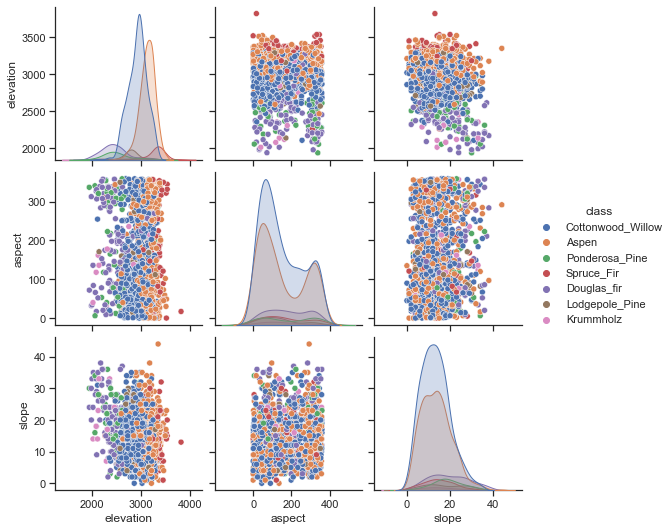

In [6]:
# Using seaborn to build the scatter matrix
# only first 3 columns, first 1000 examples
n_points = 1500
df = pd.DataFrame(X[:n_points,:3], columns=features[:3])
df['class'] = [classes[i] for i in y[:n_points]]
sns.set(style="ticks")
sns.pairplot(df, hue="class");

## Exercise 1: Random Forests
Implement a function `evaluate_RF` that measures the performance of a Random Forest Classifier, using trees
of (max) depth 2,8,32,64, for any number of trees in the ensemble (`n_estimators`). 
For the evaluation you should measure accuracy using 3-fold cross-validation. 
Use `random_state=1` to ensure reproducibility. Finally, plot the results for at least 5 values of `n_estimators` ranging from 1 to 30. You can, of course, reuse code from earlier labs and assignments. Interpret the results.
You can take a 50% subsample to speed the plotting.

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, random_state=1, test_size=0.5)

In [12]:
def evaluate_RF(search):
    
    max_depth = search.cv_results_["param_max_depth"]
    n_estimators = search.cv_results_["param_n_estimators"]
    cv_scores = search.cv_results_["mean_test_score"]
    
    unique_max_depth = np.unique(max_depth)
    
    for depth in unique_max_depth:
        
        idx = [i for i, d in enumerate(max_depth) if d == depth]
        n_est = [n_estimators[i] for i in idx]
        scores = [cv_scores[i] for i in idx]
        
        plt.plot(n_est, scores, label=depth)
    
    plt.ylim(0, 1)
    plt.legend(title="max_depth")
    plt.xlabel("n_estimators")
    plt.ylabel(search.scorer_.__repr__().split("(")[-1].split(")")[0])
    plt.title(search.best_estimator_.__class__.__name__)
    plt.show()
    

In [9]:
n_estimators = np.linspace(1, 30, 5).astype(int)
max_depth = [2, 8, 32, 64]

rfc = RandomForestClassifier(random_state=1)
search = GridSearchCV(rfc, 
                      {"n_estimators": n_estimators, "max_depth": max_depth}, 
                      scoring="accuracy", 
                      cv=3,
                      n_jobs=-1)

In [10]:
search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [2, 8, 32, 64],
                         'n_estimators': array([ 1,  8, 15, 22, 30])},
             scoring='accuracy')

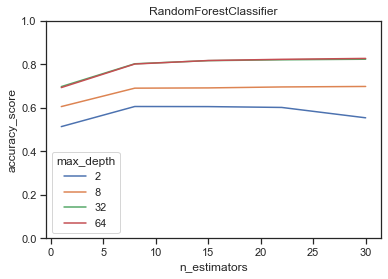

In [13]:
evaluate_RF(search)

* For small depth of trees(2) the forest performs poorly no matter how many of trees it has. Accuracy is even reduced at higher number of estimators, presumably as many trees with high bias developed.

* For medium depth(8) the results are better, but saturate at low level of accuracy and do not improve with higher number of trees.

* For high depth(32, 64) the results follow same behaviour as with medium depth, but reach much better accuracy. Small improvements can be seen at high n_estimators values, but they come at cost of longer training time.

Overall, as mentioned in lecture, Random Forest requires complex trees(high variance) and can achieve better results up to some number of trees, afterwards it saturates.

## Exercise 2: Other measures
Repeat the same plot but now use balanced_accuracy as the evaluation measure. See the [documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score).
Only use the optimal max_depth from the previous question. Do you see an important difference?

In [14]:
rfc = RandomForestClassifier(random_state=1)
search = GridSearchCV(rfc, 
                      {"n_estimators": n_estimators, "max_depth": [32]}, 
                      scoring="balanced_accuracy", 
                      cv=3,
                      n_jobs=-1)

In [15]:
search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [32],
                         'n_estimators': array([ 1,  8, 15, 22, 30])},
             scoring='balanced_accuracy')

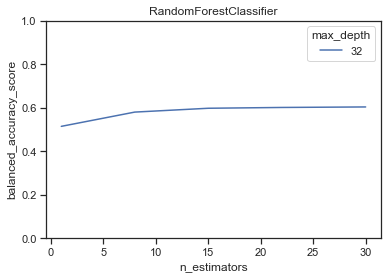

In [16]:
evaluate_RF(search)

* Accuracy reduced significantly, as it is now using mean of sensitivity and specificity and is more sensitive to bad performance on minor classes.
* Performance stops improving visibly towards 30 trees, clearly more complex model is needed.

## Exercise 3: Feature importance
Retrieve the feature importances according to the (tuned) random forest model. Which features are most important?

In [17]:
rfc = search.best_estimator_

In [18]:
print(search.best_params_)

{'max_depth': 32, 'n_estimators': 30}


In [19]:
features_sorted = sorted(zip(features, rfc.feature_importances_), key=lambda elem: -elem[1])
features_sorted_names = [elem[0] for elem in features_sorted]
features_sorted_values = [elem[1] for elem in features_sorted]

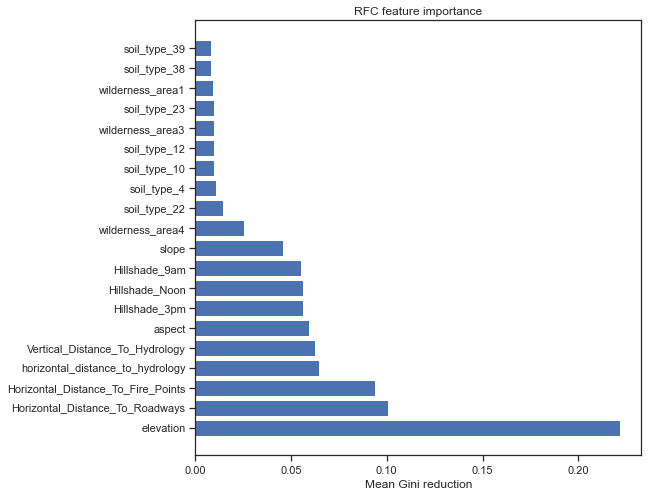

In [20]:
plt.figure(figsize=(8, 8))

plt.barh(features_sorted_names[0:20], features_sorted_values[0:20])
plt.xlabel("Mean Gini reduction")
plt.title("RFC feature importance")
plt.show()

Elevation is expectedly the most important. Other important features also are some information on geographical position of the tree, like distance to nearest roadway(polution), water etc.

## Exercise 4: Feature selection
Re-build your tuned random forest, but this time only using the first 10 features.
Return both the balanced accuracy and training time. Interpret the results.

In [21]:
import time
from sklearn.model_selection import cross_val_score

def print_elapsed_time(X, y):
    rfc = RandomForestClassifier(max_depth=32, n_estimators=30, random_state=1)
    start = time.time()
    scores= cross_val_score(rfc, X, y, cv=3, scoring="balanced_accuracy")
    end = time.time()
    print(f"Elapsed time: {end - start:.3f} seconds")
    print(f"Balanced accuracy: {scores.mean():.3f}")

In [22]:
idxs = [features.index(name) for name in features_sorted_names[0:10]]
X_top = np.stack([X_train[:, i] for i in idxs], axis=-1)

print("Top features")
print_elapsed_time(X_top, y_train)

Top features
Elapsed time: 19.755 seconds
Balanced accuracy: 0.573


In [23]:
print("All features")
print_elapsed_time(X_train, y_train)

All features
Elapsed time: 16.118 seconds
Balanced accuracy: 0.604


* Training time is similar.
* The score is a bit worse, this can be explained by that Gini importance sometimes highlights features with high cardinality(why?) although they are not very important. 

## Exercise 5: Confusion matrix
Do a standard stratified holdout and generate the confusion matrix of the tuned random forest. Which classes are still often confused?

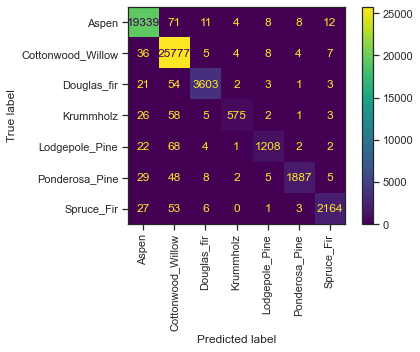

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(rfc, X_train, y_train, display_labels=classes, xticks_rotation="vertical")
plt.show()

* Minority classes are often missclassified by one of the two majority classes(Aspen and Cottonwood Willow).
* Missclassification between minority classes themselves are rather rare.

## Exercise 6: A second-level model
Build a binary model specifically to correctly choose between the first and the second class.
Select only the data points with those classes and train a new random forest. Do a standard stratified split and plot the resulting ROC curve. Can we still improve the model by calibrating the threshold?

In [45]:
X_filtered = np.array([X[i, :] for i in range(len(y)) if y[i] in [0, 1]])
y_filtered = np.array([y[i] for i in range(len(y)) if y[i] in [0, 1]])

In [47]:
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_filtered, y_filtered, 
                                                            stratify=y_filtered, 
                                                            shuffle=True, 
                                                            random_state=1, 
                                                            test_size=0.3)

In [49]:
rfc = RandomForestClassifier(max_depth=32, n_estimators=30, random_state=1)

In [50]:
rfc.fit(X_train_f, y_train_f)

RandomForestClassifier(max_depth=32, n_estimators=30, random_state=1)

In [81]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test_f, rfc.predict_proba(X_test_f)[:, 1])

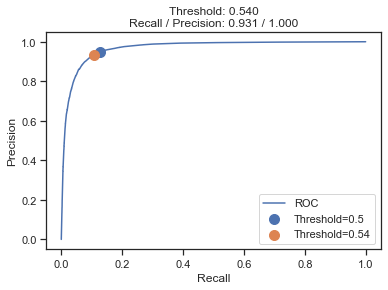

In [119]:
plt.plot(fpr, tpr, label="ROC")

t = [0.5, 0.54]
idxs = []
for i in range(len(t)):
    idxs.append(np.argmin(np.abs(thresholds - t[i])))

for i in range(len(idxs)):
    plt.scatter(fpr[idxs[i]], tpr[idxs[i]], s=100, label=f"Threshold={t[i]}", zorder=2)
    
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.title(f"Threshold: {t[1]:.3f}\nRecall / Precision: {recall[idxs[1]]:.3f} / {precision[idxs[1]]:.3f}")
plt.show()

In [118]:
from sklearn.metrics import accuracy_score

print(f"Defaut threshold accuracy: {accuracy_score(y_test_f, rfc.predict(X_test_f)):.3f}")
print(f"Tuned threshold accuracy: {accuracy_score(y_test_f, rfc.predict_proba(X_test_f)[:, 1] > 0.54):.3f}")

Defaut threshold accuracy: 0.916
Tuned threshold accuracy: 0.916


## Exercise 7: Model calibration
For the trained binary random forest model, plot a calibration curve (see [course notebook](https://ml-course.github.io/engineer/slides_html/03%20-%20Model%20Selection.slides.html#/40)). 
Next, try to correct for this using Platt Scaling (or sigmoid scaling).

Probability calibration should be done on new data not used for model fitting. The class [CalibratedClassifierCV](https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py) uses a cross-validation generator and estimates for each split the model parameter on the train samples and the calibration of the test samples. The probabilities predicted for the folds are then averaged. Already fitted classifiers can be calibrated by CalibratedClassifierCV via the parameter cv=”prefit”. [Read more](https://scikit-learn.org/stable/modules/calibration.html)

## Exercise 8: Gradient Boosting
Implement a function `evaluate_GB` that measures the performance of `GradientBoostingClassifier` or the `XGBoostClassifier` for 
different learning rates (0.01, 0.1, 1, and 10). As before, use a 3-fold cross-validation. You can use a 5% stratified sample of the whole dataset.
Finally plot the results for `n_estimators` ranging from 1 to 100. Run all the GBClassifiers with `random_state=1` to ensure reproducibility.

Implement a function that plots the score of `evaluate_GB` for `n_estimators` = 10,20,30,...,100 on a linear scale.

In [120]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, random_state=1, test_size=0.95)

In [133]:
def evaluate_GB(search):
    
    learning_rate = search.cv_results_["param_learning_rate"]
    n_estimators = search.cv_results_["param_n_estimators"]
    cv_scores = search.cv_results_["mean_test_score"]
    
    unique_learning_rate = np.unique(learning_rate)
    
    for rate in unique_learning_rate:
        
        idx = [i for i, lr in enumerate(learning_rate) if np.isclose(lr, rate)]
        n_est = [n_estimators[i] for i in idx]
        scores = [cv_scores[i] for i in idx]
        
        plt.plot(n_est, scores, label=rate)
    
    plt.ylim(0, 1)
    plt.legend(title="param_learning_rate")
    plt.xlabel("n_estimators")
    plt.ylabel(search.scorer_.__repr__().split("(")[-1].split(")")[0])
    plt.title(search.best_estimator_.__class__.__name__)
    plt.show()

In [135]:
n_estimators = np.linspace(10, 100, 10).astype(int)
learning_rates = np.logspace(-2, 1, 4)

gb = GradientBoostingClassifier(random_state=1)
search = GridSearchCV(gb, 
                      {"n_estimators": n_estimators, "learning_rate": learning_rates}, 
                      scoring="balanced_accuracy", 
                      cv=3,
                      n_jobs=-1)

In [136]:
search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=1),
             n_jobs=-1,
             param_grid={'learning_rate': array([ 0.01,  0.1 ,  1.  , 10.  ]),
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])},
             scoring='balanced_accuracy')

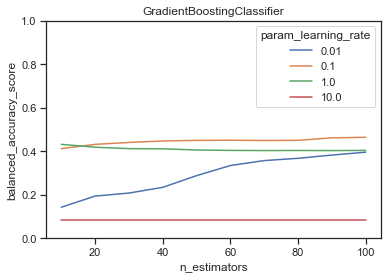

In [137]:
evaluate_GB(search)

* Learning rate 0.1 has shown best results with minimal variance by n_estimators.
* Learning rate 0.01 goes near, but needs substantially more estimators(steps) to start achiving comparable accuracy.
* Learning rate 1 is quite big and diverges slowly with increasing number of trees(steps).
* Learning rate 10 is too big and does not learn at all.